## Pseudobulk analysis for cluster marker genes and relevant visualizaitons
## Fan Zhang
## 2021-08-17

In [1]:
library(magrittr)
library(gridExtra)
library(MASS)
library(ggplot2)
library(Matrix)
library(dplyr)
library(rpart)
library(glmnet)
library(data.table)
library(presto)
library(singlecellmethods)
library(illuminaHumanv3.db)
library(lmerTest)
library(irlba)
library(uwot)
library(parallel)
library(lme4)
library(DESeq2)
library(edgeR)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggthemes)
library(RColorBrewer)
library(matrixStats)
library(viridis)
library(grid)
library(Seurat)
library(harmony)
library(scico) 
library(ComplexHeatmap)
library(ggrastr)

meta_colors = list(

 "cell_type" = c(
       "B cell" = "#A65628",
        "Fibroblast" = "#A6CEE3",
        "Endothelial" = "#1F78B4",
        "Myeloid" = "#FB8072",
        "T cell" = "#CAB2D6",
        "NK" = "#6A3D9A"
     ),
    
    "CTAP" = c(
        "M" = "#9E0142",
        "TM" = "#F46D43",
        "TB" = "#FEE08B",
        "TF" = "#E6F598",
        "F" = "#ABDDA4",
        "EFM" = "#66C2A5",
        "OA" = "grey"
    ) 
)


# Load raw count data

In [2]:
mRNA_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/mRNA_exprs_2020-01-24.rds")

In [3]:
# Load myeloid reference
ref <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/myeloid_reference_2021-04-29.rds")
meta_data <- ref$meta_data

meta_umap <- as.data.frame(ref$umap$embedding)
meta_data <- cbind(meta_data, meta_umap)

Warning message:
"`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


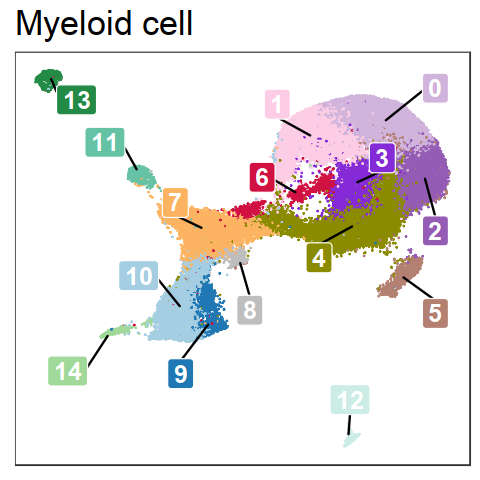

In [6]:
# Plot clusters
meta_data$cluster_number <- factor(meta_data$cluster_number, 
                                levels = seq(0, 14)
                               )




cluster_center <- meta_data %>%
                  group_by(cluster_number) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cluster_number <- as.character(cluster_center$cluster_number)

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(meta_data[sample(nrow(meta_data)),],
       aes(x = UMAP1, y = UMAP2, fill= cluster_number)
      ) +
  geom_point_rast(size = 0.7, stroke = 0.0001, shape = 21) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cluster_number, fill = cluster_number), 
    size = 5.2, 
    color = 'white',
    fontface = 'bold', 
    box.padding = unit(0.9, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'black'
  ) +
  scale_fill_manual( values = c("#d0b4dc", "#FCCDE5", "#945cb4", "#842bd7", "yellow4", "#B38072","#d11141", 
                                "#FDB462", "grey", "#1F78B4", "#A6CEE3", "#66C2A4", "#CCECE6", "#238B45", "#A1D99B"),
                    name = "") +
  guides( fill = guide_legend(override.aes = list(shpae = 15, size = 2))) +
  labs(
      x = NULL,
      y = NULL,
      title = "Myeloid cell"
      ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
    )

ggsave(file = paste("myeloid_umap_cluster", ".pdf", sep = ""), width = 4, height = 4, dpi = 300)

In [7]:
meta_colors$cluster_color <- c(
        'MERTK+ SELENOP+ LYVE1+: M-0' = '#d0b4dc',
        'MERTK+ SELENOP+ LYVE1-: M-1' = '#FCCDE5',
        'MERTK+ S100A8+: M-2' = '#945cb4',
        'MERTK+ HBEGF+: M-3' = '#842bd7',
        'SPP1+: M-4' = 'yellow4',
        'C1QA+: M-5' = '#B38072',
        'STAT1+ CXCL10+: M-6' = '#d11141',
        'IL1B+ FCN1+: M-7' = '#FDB462',
        'PLCG2+: M-8' = 'grey',
        'DC3: M-9' = '#1F78B4',
        'DC2: M-10' = '#A6CEE3',
        'DC4: M-11' = '#66C2A4',
        'DC1: M-12' = '#CCECE6',
        'pDC: M-13' = '#238B45',
        'LAMP3+: M-14' = '#A1D99B'
    )

In [22]:
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)
for (i in dev.list()[1]:dev.list()[length(dev.list())]) {
   dev.off()
}

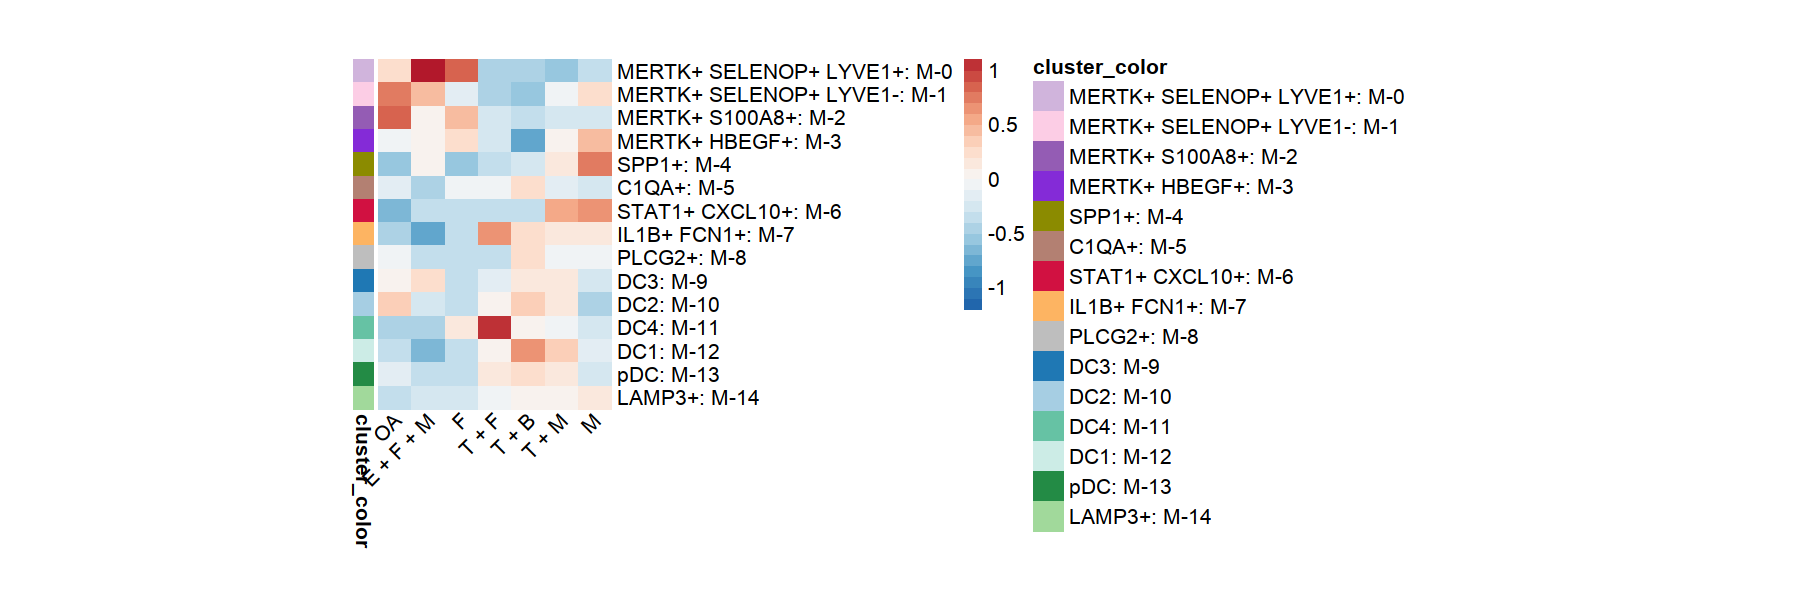

In [26]:
library(stringr)
mat_z_class <- as.data.frame(t(mat_z))
mat_z_class$new_class <- annotation_col$new_class

mat_z_mean <- mat_z_class %>%
              group_by(new_class) %>%
              summarise_all("mean")
mat_z_mean <- as.data.frame(t(mat_z_mean))
colnames(mat_z_mean) <- as.character(t(mat_z_mean[1,]))
mat_z_mean <- mat_z_mean[-1,]
row_name <- rownames(mat_z_mean)
row_name <- paste0(sub('.*: ', "", rownames(mat_z_mean)), ": ", sub("\\:.*", "", rownames(mat_z_mean)), sep = "")
col_name <- colnames(mat_z_mean)
mat_z_mean <- data.frame(apply(mat_z_mean, 2, function(x) as.numeric(as.character(x))))
colnames(mat_z_mean) <- col_name
rownames(mat_z_mean) <- row_name            
                               
annot_row = data.frame(
    cluster_color = rownames(mat_z_mean)
)
annot_row$cluster_color <- as.character(annot_row$cluster_color)
rownames(annot_row) <- annot_row$cluster_color
annot_col = data.frame(
    new_class = col_name
)
annot_col$new_class <- as.character(annot_col$new_class)                               
                               
options(repr.plot.height = 5, repr.plot.width = 15)
# Create pheatmap in PDF file!
filename <- "heatmap_rowscale_myeloid_cluster_mean.pdf"
hm.parameters <- list(
          mat = mat_z_mean[, -ncol(mat_z_mean)], 
          breaks =  seq(-max(mat_z_mean), max(mat_z_mean), 0.1), # mat_breaks,
          color  = colorRampPalette(rev(brewer.pal(n=9,name="RdBu")))(2*max(mat_z_mean)/0.1), # scico(30, palette = 'vik'),
          border_color = NA,
          cellwidth = 20, cellheight = 14,
#           annotation_col    = annot_col,
          annotation_row    = annot_row,
          annotation_colors = meta_colors,
          show_rownames = TRUE,
          show_colnames = TRUE,
          cluster_rows = FALSE,
          cluster_cols = FALSE,
          fontsize = 12,
          fontsize_row = 12
        )
 
  # To draw the heat map on screen 
  do.call("pheatmap", hm.parameters)
 
  # To draw to file 
  do.call("pheatmap", c(hm.parameters, filename=filename))

# pseudobulk analysis

In [4]:
# Generate pseudobulk matrix
exprs_raw <- mRNA_exprs[, meta_data$cell]
all(colnames(exprs_raw) == meta_data$cell)

all_collapse <- collapse_counts(exprs_raw, meta_data, c("cluster_number", "sample"))

# For the purpose of future visualization at per-cell level
exprs_norm <- exprs_raw %>% NormalizeDataSeurat()

rm(mRNA_exprs)
rm(exprs_raw)

In [100]:
# Normalize pseudobulk matrix
cutoff <- 30
drop <- which(apply(all_collapse$counts_mat, 1, max) < cutoff)
d <- all_collapse$counts_mat[-drop,]
dim(d)
tmp <- log2(cpm(d)+1)

[1] 13324  1122

In [101]:
group <- interaction(all_collapse$meta_data$cluster_number)
cell_umi <- apply(all_collapse$counts_mat, 2, function(x) {log2(sum(x) + 1)})
donor <- interaction(all_collapse$meta_data$sample)

mm <- model.matrix(~0 + group + donor + cell_umi)
colnames(mm) <- gsub("-", ".", colnames(mm))

In [98]:
# Diferential expression for one gene

diffexp_lm <- function(gexp, gname, min_clus, max_clus, mm) {
    Reduce(rbind, lapply(min_clus:max_clus, function(x) {
        m <- lm(gexp~., data = data.frame(mm[,colnames(mm) == paste0("group", x) | !grepl("group", colnames(mm))]))
        m_null <- lm(gexp~., data = data.frame(mm[,!grepl("group", colnames(mm))]))

        m_chisq <- anova(m_null, m, test = "LRT")
        m_f <- anova(m_null, m, test = "F")
        m_f_var <- anova(m, test = "F")
        c(summary(m)$coefficients[2,], m_chisq$`Sum of Sq`[2], m_chisq$P[2], m_f$F[2], m_f$P[2], m_f_var$F[1], m_f_var$P[1], gname, x)
    }))
}

,gene.mean,gene.dispersion
,<dbl>,<dbl>
AL669831.5,3.501032,6.206036
LINC00115,3.168456,6.371669
FAM41C,2.513403,5.439155
NOC2L,5.101501,6.025638


[1] 4694

[1] TRUE

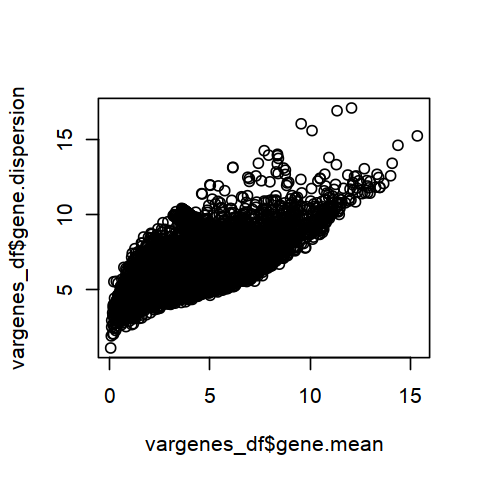

In [95]:
# Find varible genes to further identify most differential expressed genes in the next step
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(tmp), value = TRUE)
vargenes_df <- FindVariableGenesSeurat(tmp, meta_data, genes_exclude, 0.7e3)
vargenes_df[1:4, ]
plot(vargenes_df$gene.mean, vargenes_df$gene.dispersion)
varg <- which(vargenes_df$gene.dispersion > 5 & vargenes_df$gene.mean > 5)
length(varg)

"LYVE1" %in% row.names(tmp)

In [ ]:
# Run it on all or a subset of genes
results <- Reduce(rbind, lapply(varg, function(x) {
    diffexp_lm(tmp[x,], row.names(tmp)[x], 0, 14, mm)}
))
saveRDS(results, "pseudobulk_myeloid.rds")

In [11]:
results <- readRDS("pseudobulk_myeloid.rds")
dim(results)

[1] 70410    12

In [5]:
results_temp <- results[, c(1,2,3,4, ncol(results)-1, ncol(results))]
colnames(results_temp) <- c("Estimate", "Std_error", "t_value", "p_value", "gene", "cluster_number")
rownames(results_temp) <- seq(1, nrow(results_temp))
results_temp <- as.data.frame(results_temp)

table(results_temp$cluster_number)
results_temp <- cbind(lapply(results_temp[, c(1:4)], function(x) as.numeric(as.character(x))), results_temp[, c(5,6)])
results_temp$log_p_value <- -log10(results_temp$p_value)

In [16]:
results_temp[which(results_temp$gene == "HBEGF"),]

,Estimate,Std_error,t_value,p_value,gene,cluster_number,log_p_value
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
20746,-1.4305559,0.2661561,-5.374875,9.462841e-08,HBEGF,0,7.0239784
20747,0.9039356,0.2714260,3.330321,8.979945e-04,HBEGF,1,3.0467263
20748,-1.6562356,0.2663059,-6.219298,7.227756e-10,HBEGF,2,9.1409965
20749,1.2433028,0.2704990,4.596331,4.828636e-06,HBEGF,3,5.3161755
20750,0.3474986,0.2724176,1.275610,2.023788e-01,HBEGF,4,0.6938349
20751,-1.1867770,0.2688092,-4.414942,1.116084e-05,HBEGF,5,4.9523031
20752,0.4934879,0.2845415,1.734327,8.315701e-02,HBEGF,6,1.0801011
20753,2.1908308,0.2591033,8.455435,9.328152e-17,HBEGF,7,16.0302044
20754,1.9692358,0.2990432,6.585122,7.206485e-11,HBEGF,8,10.1422765


In [6]:
p_thresh <- 0.05/ (length(varg)*length(names(table(meta_data$cluster_number))))
p_thresh
results_good <- results_temp[which(results_temp$log_p_value > -log10(p_thresh) & results_temp$Estimate > 2),]

# Visualize pseudobulk genes in heatmap

In [17]:
# Use canonical_marker from Northwestern paper
# gene_plot <- unique(results_good$gene)
gene_plot <- c("CD68", "FCGR3A", "FN1", "ITGAM", "MARCO", "VSIG4", "C1QA", "RNASE1", "APOE", "SCARB2",
              "MMP2", "IFI27", "NUPR1", "HTRA1", "TIMD4", "FERMT2", "F13A1", "SLCO2B1", "STAB1", "MERTK",
              "CCL18", "FOLR2", "COLEC12", "CCL13", "SELENOP", "SLC40A1", "LYVE1", "S100A8", "VCAN", "CLEC5A",
              "FCGR2A", "CD14", "FCGR1A", "CXCL3", "IFIT3", "IFIT1", "CCL8", "CXCL11", "CXCL10", "SPP1", "FABP5",
              "LPL", "FABP4", "IER3", "ATF3", "HBEGF", "EREG", "EGR1", "IER5L", "TNF", "PLCG2", "CEBPA", "IFITM3",
              "ITGAX", "PLAUR", "IL1B", "SMIM25", "CX3CR1", "HES4", "CDKN1C", "TCF7L2", "RGS2", "PID1", "FCN1",
              "S100A12", "CCR2", "CD36", "PLAC8", "TCF4", "CLEC4C", "PTGDS", "GZMB", "HLA-DRA", "CLEC10A", "FCER1A",
              "IL1R2", "CD1C", "FLT3", "CST7", "CAMP", "XCR1", "CLEC9A", "JAK1", "LAP3", "TBX21", "CXCL9", "GBP1",
              "G0S2", "CXCL13", "CCL17", "FSCN1", "EBI3", "LAMP3", "CCL19", "CCR7", "THBD")

gene_plot <- unique(gene_plot)
length(gene_plot)

exp_heat <- exprs_norm[gene_plot,]
exp_heat <- as.data.frame(t(exp_heat))
exp_heat$cluster_name <- as.character(meta_data$cluster_name)
dim(exp_heat)

exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$cluster_name), mean)
colnames(exp_ave)[1] <- "cluster_name"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)

exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names
exp_ave <- as.matrix(exp_ave)

exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2
dim(exp_ave_scale)

[1] 96

[1] 76181    97

[1] 96 15

In [193]:
## Save genes and statistics into table
result_save <- results_temp[which(results_temp$gene %in% gene_plot),]
result_save <- result_save[which(result_save$p_value < p_thresh & result_save$Estimate > 2),]
result_save$cluster_number <- as.numeric(as.character(result_save$cluster_number))
dim(result_save)

result_save <- result_save %>% group_by(cluster_number) %>% top_n(n=10) %>% arrange(desc(Estimate))
dim(result_save)

result_save <- result_save[, c("cluster_number", "gene", "Estimate", "p_value")]
result_save <- result_save[order(result_save$cluster_number),]

result_save <- result_save[, c("cluster_number", "cluster_name", "gene", "Estimate", "p_value")]
result_save[, 4] <- round(result_save[, 4], digits = 2)

colnames(result_save) <- c("Cluster number", "Cluster annotation", "Gene", "FC", "Likelihood ratio test p-value")
dim(result_save)
result_save[1:4,]

saveRDS(result_save, "myeloid_cluster_marker_gene.rds")

[1] 154   7

Selecting by log_p_value



[1] 125   7

[1] 1.87261e-08

[1] 2


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 
10  6 10 10  5 10 10 10  9  7 10 10  2  6 10 

[1] 125   5

,Cluster number,Cluster annotation,Gene,FC,Likelihood ratio test p-value
,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,0,M-0: MERTK+ SELENOP+ LYVE1+,SELENOP,4.68,2.679859e-34
2,0,M-0: MERTK+ SELENOP+ LYVE1+,LYVE1,4.42,3.452965e-55
3,0,M-0: MERTK+ SELENOP+ LYVE1+,CCL13,3.68,2.043183e-41
4,0,M-0: MERTK+ SELENOP+ LYVE1+,CCL18,3.66,2.922049e-25


In [ ]:
subset <- which(rownames(exp_ave_scale) %in% rownames(exp_ave_scale))
labels = rownames(exp_ave_scale)[subset]
col_fun <- scico(10, palette = 'vik') # 'bamako'

pdf("myeloid_heatmap.pdf", width = 6, height = 20)
Heatmap(exp_ave_scale, 
        col = col_fun,
        row_names_gp = gpar(fontsize = 15),
        column_km = 2,
        column_names_rot = 45,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_column_names = TRUE,
        show_row_names = FALSE, 
        show_row_dend = FALSE, 
        show_column_dend = FALSE
       ) +
rowAnnotation(link = row_anno_link(at = subset, labels = labels),
              width = unit(1, "cm") + 
              max_text_width(labels)
             )
dev.off()


# Visualize protein expressions in umap

In [17]:
# Load filtered proteins
# 1. CLR normalized protein expression: /data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_2020-01-25.rds
# 2. Remove background based on global gaussian mixture model: /data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds
adt_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds")
adt_exprs <- adt_exprs[, meta_data$cell]
dim(adt_exprs)
rownames(adt_exprs) <- substr(rownames(adt_exprs),1,nchar(rownames(adt_exprs))-5) 
rownames(adt_exprs)

[1]    58 76181

[1] "CD107a/LAMP1"                  "CD112/Nectin-2"               
 [3] "CD119/IFN-gamma-R-alpha-chain" "CD11b"                        
 [5] "CD11c"                         "CD127/IL-7R-alpha"            
 [7] "CD140a/PDGFR-alpha"            "CD141/Thrombomodulin"         
 [9] "CD144/VE-Cadherin"             "CD146"                        
[11] "CD14"                          "CD155/PVR"                    
[13] "CD161"                         "CD163"                        
[15] "CD16"                          "CD192/CCR2"                   
[17] "CD195/CCR5"                    "CD196/CCR6"                   
[19] "CD19"                          "CD1c"                         
[21] "CD206/MMR"                     "CD209/DC-SIGN"                
[23] "CD20"                          "CD21"                         
[25] "CD226/DNAM-1(11A8)"            "CD24"                         
[27] "CD273/B7-DC/PD-L2"             "CD274/B7-H1/PD-L1"            
[29] "CD278/ICOS"                    "CD279/PD-1"                   
[31] "CD27(LG.3A10)"                 "CD304/Neuropilin-1"           
[33] "CD309/VEGFR2"                  "CD314/NKG2D"                  
[35] "CD31"                          "CD34"                         
[37] "CD38(HIT2)"                    "CD3"                          
[39] "CD44"                          "CD45(2D1)"                    
[41] "CD45RA"                        "CD45RO"                       
[43] "CD4"                           "CD55"                         
[45] "CD56/NCAM"                     "CD64"                         
[47] "CD68"                          "CD69"                         
[49] "CD86"                          "CD8a"                         
[51] "CD90/THY1"                     "CX3CR1"                       
[53] "EGFR"                          "FR-beta"                      
[55] "HLA-DR"                        "IgG-Fc"                       
[57] "IgM"                           "Podoplanin"

In [18]:
meta_umap <- as.data.frame(ref$umap$embedding)
dim(meta_umap)

[1] 76181     2

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

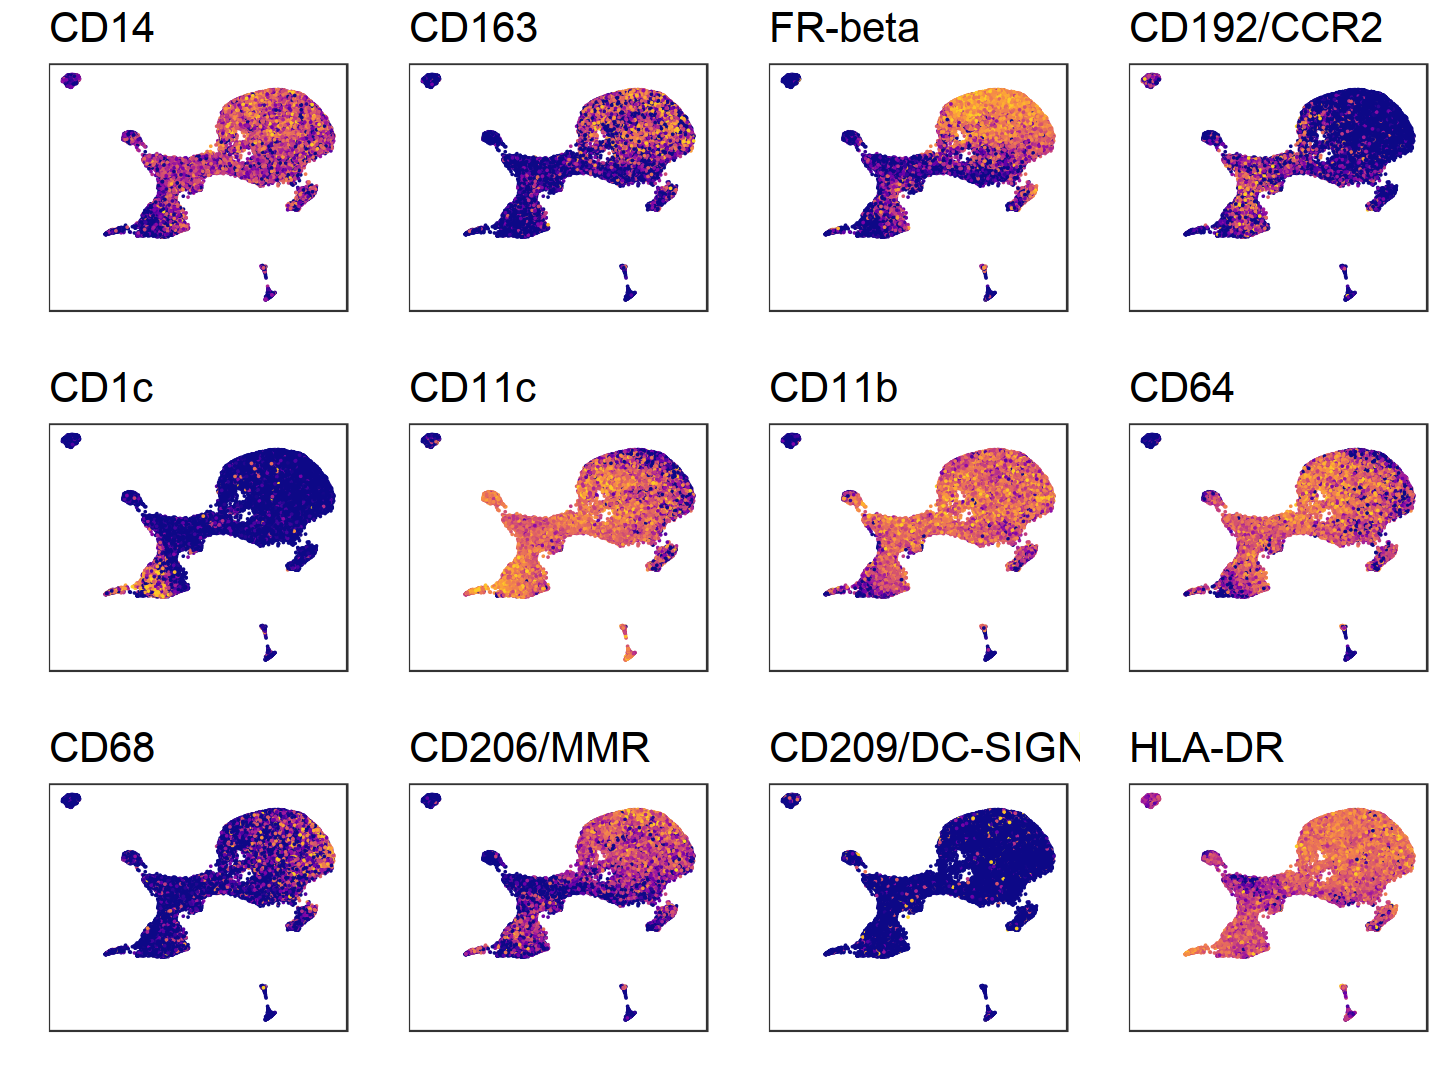

In [7]:
plot_protein <- c("CD14", "CD163", "FR-beta", "CD192/CCR2", "CD1c", "CD11c", "CD11b", "CD64", "CD68", "CD206/MMR", "CD209/DC-SIGN", "HLA-DR")
plot_protein %in% rownames(adt_exprs)

myplots <- list()
for (i in 1:length(plot_protein)) {
    protein <- plot_protein[i]
    max.cutoff = quantile(adt_exprs[protein,], .99)
    min.cutoff = quantile(adt_exprs[protein,], .01)

    tmp <- sapply(X = adt_exprs[protein,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    meta_umap$protein <- as.numeric(tmp)
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(
                 data = meta_umap[sample(nrow(meta_umap)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = protein), size = 0.001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=25), # face="bold.italic"
        legend.position = "none") +
      labs(title = protein)
  
    myplots[[i]] <- ind
}

options(repr.plot.height = 9, repr.plot.width = 12)
p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("myeloid_protein_umap", ".png", sep = ""), p, width = 12, height = 9, dpi = 300)

[1] TRUE TRUE TRUE TRUE

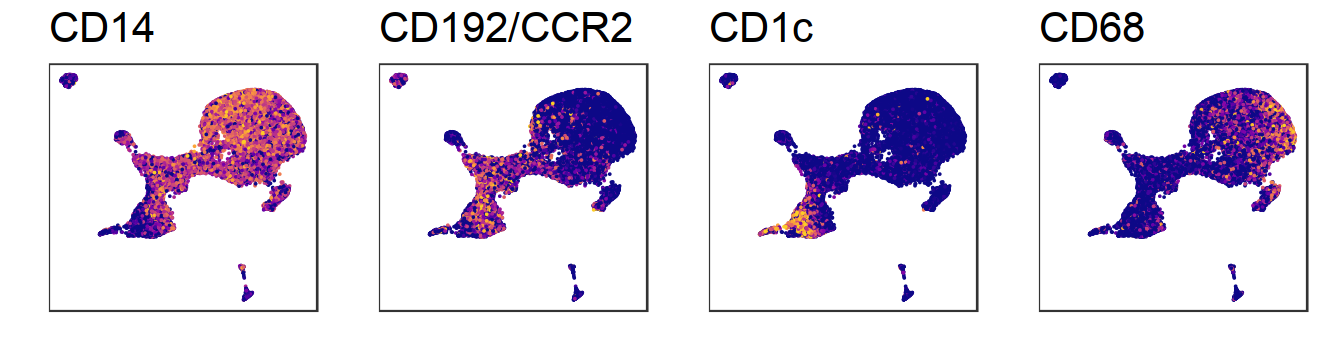

In [20]:
plot_protein <- c("CD14", "CD192/CCR2", "CD1c", "CD68")
plot_protein %in% rownames(adt_exprs)

myplots <- list()
for (i in 1:length(plot_protein)) {
    protein <- plot_protein[i]
    max.cutoff = quantile(adt_exprs[protein,], .99)
    min.cutoff = quantile(adt_exprs[protein,], .01)

    tmp <- sapply(X = adt_exprs[protein,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    meta_umap$protein <- as.numeric(tmp)
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(
                 data = meta_umap[sample(nrow(meta_umap)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = protein), size = 0.001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=25), # face="bold.italic"
        legend.position = "none") +
      labs(title = protein)
  
    myplots[[i]] <- ind
}

options(repr.plot.height = 3, repr.plot.width = 11)
p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("myeloid_protein_marker", ".png", sep = ""), p, width = 11, height = 3, dpi = 300)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

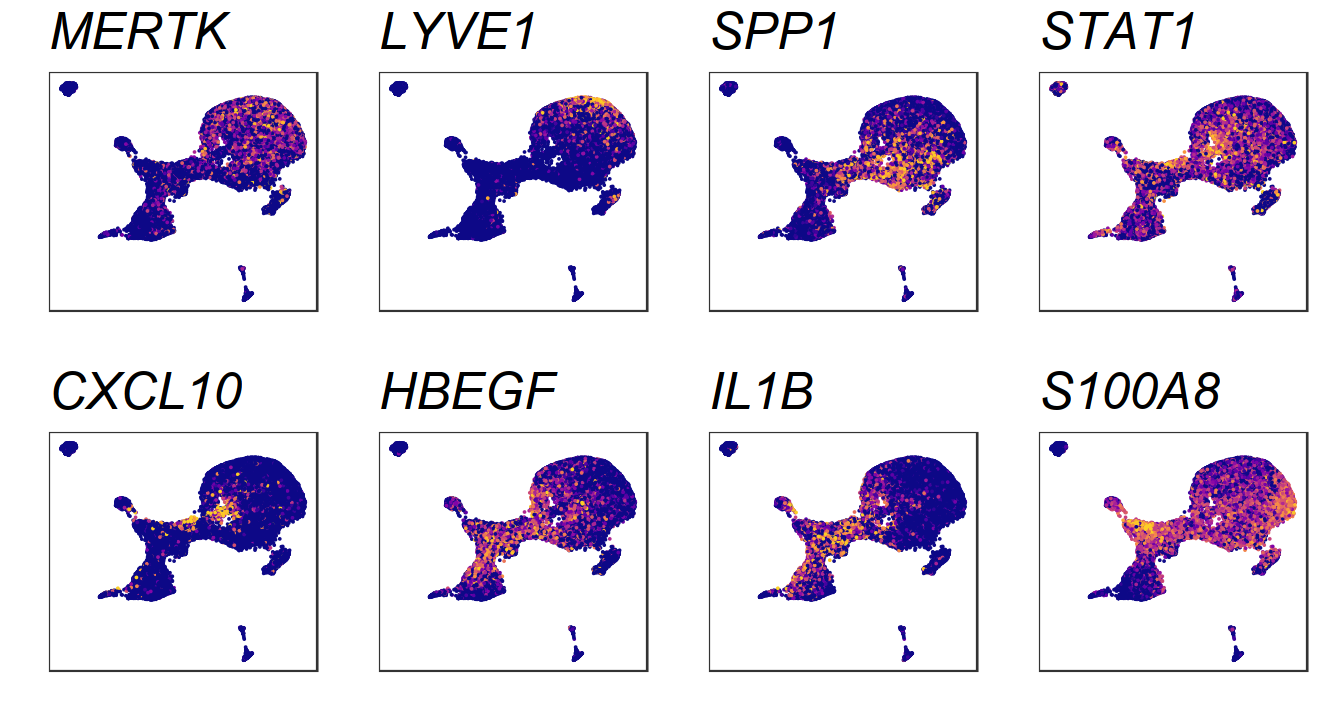

In [33]:
plot_gene <- c("MERTK", "LYVE1", "SPP1", "STAT1", "CXCL10", "HBEGF", "IL1B", "S100A8")
plot_gene %in% rownames(exprs_norm)

myplots <- list()
for (i in 1:length(plot_gene)) {
    gene <- plot_gene[i]
    max.cutoff = quantile(exprs_norm[gene,], .99)
    min.cutoff = quantile(exprs_norm[gene,], .01)

    tmp <- sapply(X = exprs_norm[gene,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    meta_umap$gene <- as.numeric(tmp)
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(
                 data = meta_umap[sample(nrow(meta_umap)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = gene), size = 0.00001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", face="italic", size=30), 
        legend.position = "none") +
      labs(title = gene)
  
    myplots[[i]] <- ind
}

options(repr.plot.height = 6, repr.plot.width = 11)
p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("myeloid_gene_marker", ".png", sep = ""), p, width = 11, height = 6, dpi = 300)

[1] TRUE TRUE TRUE TRUE

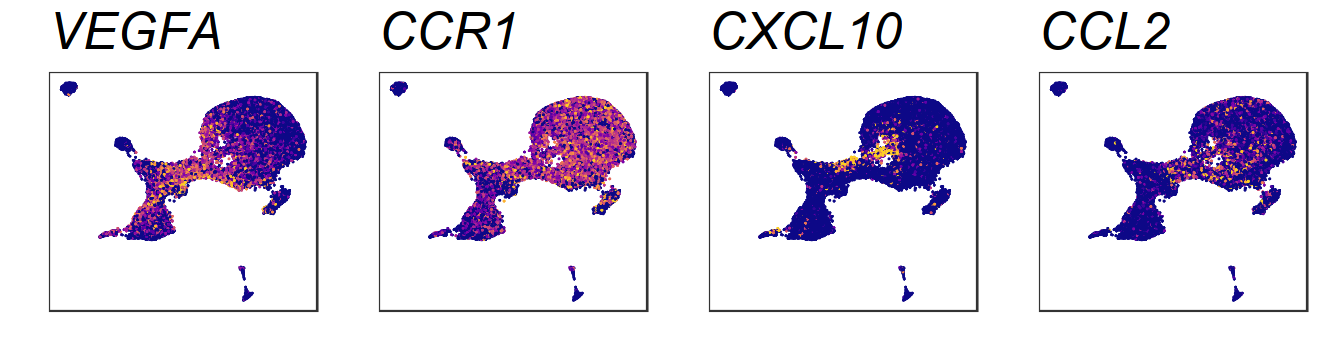

In [10]:
plot_gene <- c("VEGFA", "CCR1", "CXCL10", "CCL2")
plot_gene %in% rownames(exprs_norm)

myplots <- list()
for (i in 1:length(plot_gene)) {
    gene <- plot_gene[i]
    max.cutoff = quantile(exprs_norm[gene,], .99)
    min.cutoff = quantile(exprs_norm[gene,], .01)

    tmp <- sapply(X = exprs_norm[gene,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    meta_umap$gene <- as.numeric(tmp)
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(
                 data = meta_umap[sample(nrow(meta_umap)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point_rast(mapping = aes(color = gene), size = 0.00001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", face="italic", size=30), 
        legend.position = "none") +
      labs(title = gene)
  
    myplots[[i]] <- ind
}

options(repr.plot.height = 3, repr.plot.width = 11)
p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("myeloid_cytokines", ".pdf", sep = ""), p, width = 11, height = 3, dpi = 300)

In [5]:
dim(meta_data)
clin <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/d_pca_category_all_2021-08-03.rds")
colnames(clin)[1] <- "sample"
meta_data_ctap <- merge(x = meta_data, y = clin[, c("sample", "new_class")], by = "sample", all.x = TRUE)
dim(meta_data_ctap)
meta_data_ctap[1:4,]

# NA new_class are for OA samples

[1] 76181     6

[1] 76181     7

,sample,cell,cluster_number,cluster_name,UMAP1,UMAP2,new_class
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>
1,BRI-399,BRI-399_AAACCCAGTAGGAGGG,10,M-10: DC2,-5.021373,-4.028395,NA
2,BRI-399,BRI-399_AAACGCTGTTCAAGTC,10,M-10: DC2,-5.620600,-4.745194,NA
3,BRI-399,BRI-399_AAAGGATTCTGTACAG,0,M-0: MERTK+ SELENOP+ LYVE1+,1.777372,3.895319,NA
4,BRI-399,BRI-399_AAAGGTAAGCTGGCTC,7,M-7: IL1B+ FCN1+,-4.262743,-2.492763,NA


In [6]:
oa_sample <- c("BRI-399", "BRI-438", "BRI-442", "BRI-456", "BRI-477", "BRI-487", "BRI-517", "BRI-523", "BRI-587", "BRI-609")
meta_data_ctap[which(meta_data_ctap$sample %in% oa_sample),]$new_class <- "OA" 

In [7]:
temp5 <- table(meta_data_ctap$new_class, meta_data_ctap$cluster_name)
temp6 <- melt(temp5)
colnames(temp6) <- c("new_class", "cluster", "freq")
dim(temp6)
temp6[1:4,]

Warning message in melt(temp5):
"The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp5). In the next version, this warning will become an error."


[1] 105   3

,new_class,cluster,freq
,<fct>,<fct>,<int>
1,E + F + M,M-0: MERTK+ SELENOP+ LYVE1+,2089
2,F,M-0: MERTK+ SELENOP+ LYVE1+,2358
3,M,M-0: MERTK+ SELENOP+ LYVE1+,4083
4,OA,M-0: MERTK+ SELENOP+ LYVE1+,1798


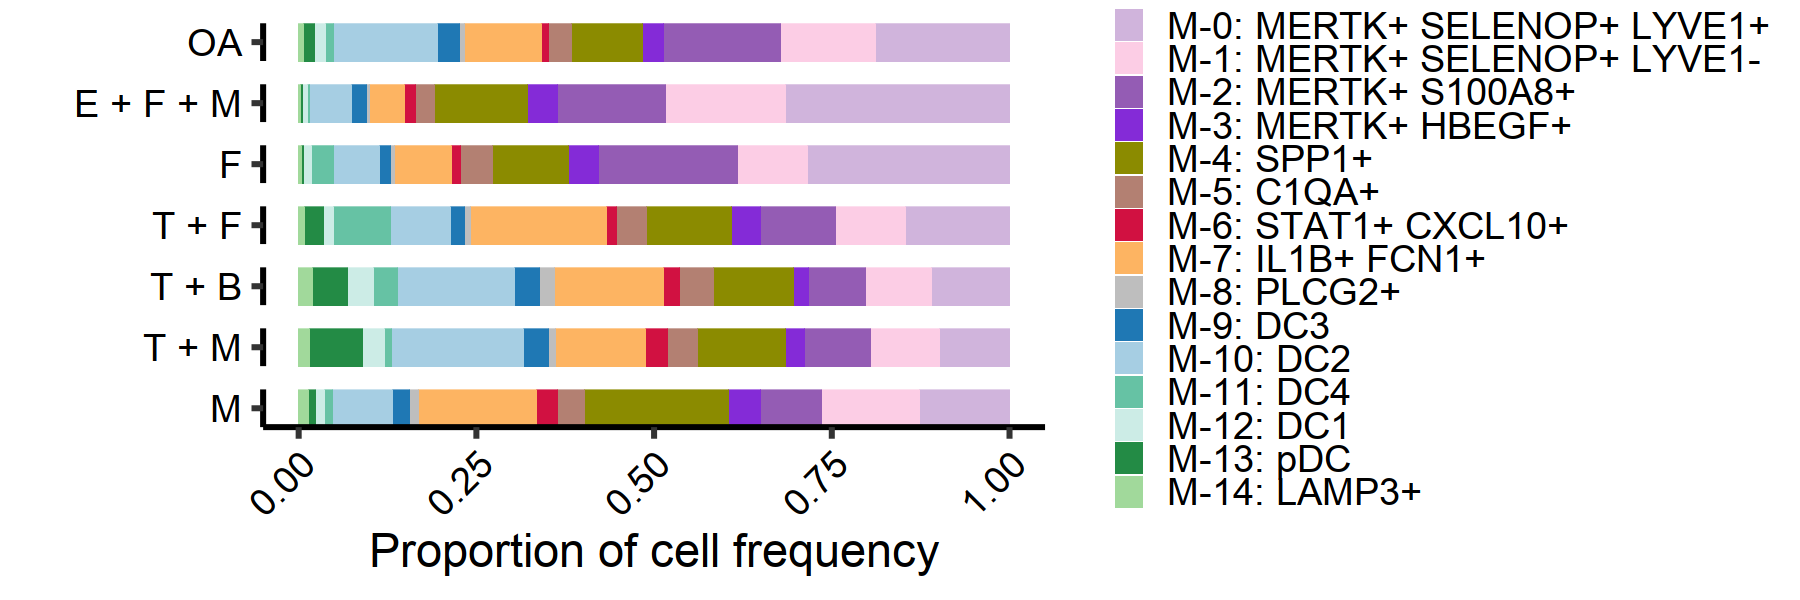

In [15]:
temp6$new_class <- factor(temp6$new_class, levels = c("OA", "E + F + M", "F", "T + F", "T + B", "T + M", "M"))

temp6$cluster <- factor(temp6$cluster, levels = c('M-0: MERTK+ SELENOP+ LYVE1+', 'M-1: MERTK+ SELENOP+ LYVE1-', 'M-2: MERTK+ S100A8+', 'M-3: MERTK+ HBEGF+', 'M-4: SPP1+',
                                                        'M-5: C1QA+', 'M-6: STAT1+ CXCL10+', 'M-7: IL1B+ FCN1+', 'M-8: PLCG2+', 'M-9: DC3', 'M-10: DC2', 'M-11: DC4', 'M-12: DC1', 'M-13: pDC', 'M-14: LAMP3+'))
                                              
options(repr.plot.height = 5, repr.plot.width = 15)
ggplot(
      temp6,
      aes(x = new_class, y=freq, fill = cluster)
      ) + 
    geom_bar(stat = "identity", 
             position = "fill", 
             width = 1.2) +
  coord_flip() +
  facet_grid(rows = vars(new_class), scales = "free_y", space = "free_y") +
  scale_fill_manual( values = c("#d0b4dc", "#FCCDE5", "#945cb4", "#842bd7", "yellow4", "#B38072","#d11141", "#FDB462", "grey", "#1F78B4", "#A6CEE3", "#66C2A4", "#CCECE6", "#238B45", "#A1D99B"), name = "") +
  labs(x = "", y = "Proportion of cell frequency") + 
  theme_classic(base_size = 28) +
  theme(
#     legend.position = "none",
        strip.text.y = element_blank(),
        strip.text.x = element_blank(),
        strip.background = element_blank(),
        axis.text.y = element_text(color="black"),
        axis.text.x = element_text(color="black", hjust = 1, angle = 45),
        panel.grid = element_blank()
  ) 
ggsave(file = paste("myeloid_barplot", ".pdf", sep = ""), width = 15, height = 5, dpi = 300)

In [10]:
temp5 <- table(meta_data_ctap$new_class, meta_data_ctap$sample)
temp6 <- melt(temp5)
colnames(temp6) <- c("new_class", "sample", "freq")
temp6$new_class <- as.character(temp6$new_class)

Warning message in melt(temp5):
"The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp5). In the next version, this warning will become an error."


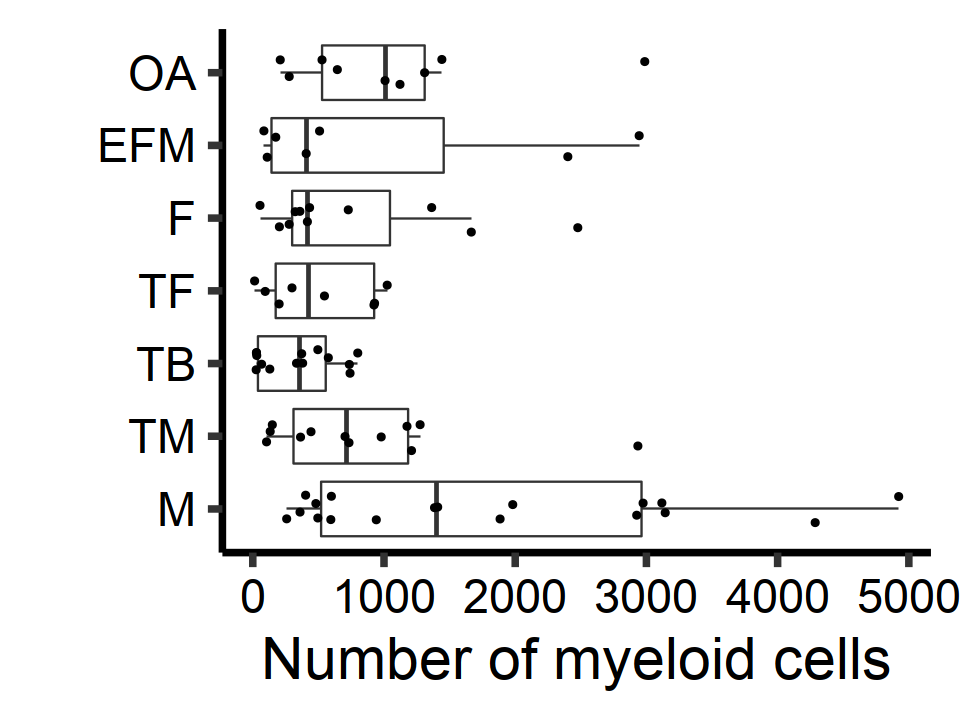

In [11]:
temp6$new_class <- factor(temp6$new_class, rev(c("OA", "EFM", "F", "TF", "TB", "TM", "M")))
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(temp6, aes(x=new_class, y=freq)) + 
  geom_boxplot(outlier.shape = NA) +
  coord_flip() +
  geom_jitter(position=position_jitter(0.2)) +
  labs(x = "", y = "Number of myeloid cells") +
  theme_classic(base_size = 35) +
  theme(
#     legend.position = "none",
        strip.text.y = element_blank(),
        strip.text.x = element_blank(),
        strip.background = element_blank(),
        axis.text = element_text(color="black"),
        panel.grid = element_blank()
  ) 

ggsave(file = paste("myeloid_barplot_excat_cellnumber", ".pdf", sep = ""), width = 8, height = 6, dpi = 300)